<a href="https://colab.research.google.com/github/sophiezla/FII-NX1Intl-SOPHIE-ZHU/blob/main/counterfeit_drug_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Counterfeit Drug Detection Project

Counterfeit drugs and flaseified medicines create a huge risk towards public health. Drug counterfeiting has increased greatly in recent years and have made their way into the legal markets.
They can be extremely harmful if taken- from contamination to under/over dosage which makes identifying and eliminating these drugs so important.
https://www.clientpharma.com/the-importance-of-detecting-counterfeit-medicines/

A very good resource right now : https://www.whpa.org/sites/default/files/2018-12/Toolkit_BeAware_Background.pdf

The dataset used in this project https://universe.roboflow.com/harshini-t-g-r/counterfeit_med_detection/dataset/4
includes images of counterfeit and authentic, plus annotations

# Load Data

In [1]:
#Load neccessary libraries for project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm import tqdm

from PIL import Image



Dataset: Counterfeit_med_detection Computer Vision Dataset
Contains 1555 unique images (Total 4260 images)

Preprocessing applied already: auto-orientations. resizing all to 640x640.

Total dataset contains 4260 total images with augumentation.
Augementations include 90 degree rotations clockwise and counter-clockwise, exposure changes between -25% and +25%

In [2]:
#create new directory to store extracted data
extracted_data = "counterfeit_med_data"
os.makedirs(extracted_data, exist_ok = True)
# unzip data file
!unzip -q /content/Counterfeit_med_detection.v4i.multiclass.zip -d {extracted_data}

Dataset is already presplit into test, train and validation. 4072 train set, 123 validation set, 65 test set.

In [3]:
#Define test, train and validation datasets
test_data = "/content/counterfeit_med_data/test"
train_data = "/content/counterfeit_med_data/train"
val_data = "/content/counterfeit_med_data/valid"

In [4]:
#Explore data
print(f'Length of train dataset: {len(os.listdir(train_data))}')
print(f'Length of validation dataset: {len(os.listdir(val_data))}')
print(f'Length of test dataset: {len(os.listdir(test_data))}')

Length of train dataset: 4073
Length of validation dataset: 123
Length of test dataset: 66


In [6]:
# Load your classes file
df = pd.read_csv("/content/counterfeit_med_data/train/_classes.csv")

# Peek at the first few rows
print(df.head())

# Count how many samples per class
class_counts = df['class'].value_counts()
print("\nClass distribution:")
print(class_counts)

                                            filename   authentic   counterfeit
0  images4110_jpg.rf.a51e0991684677a14b9133060d82...           1             0
1  images239_jpg.rf.a540397ce79b45d1f9bb91b466281...           1             0
2  images342_jpg.rf.a4eb8f802f5a983da235655539bb2...           1             0
3  images349_jpg.rf.a45a8680d4a5970bba93346bad1ed...           1             0
4  images314_jpg.rf.a5086ebc5a1623d5efdbb3d7391d1...           1             0


KeyError: 'class'

In [7]:
#Define Transforms
#Resize to 224x224
Transform = transforms.Compose([transforms.Resize((264,264)), transforms.ToTensor()])

In [8]:
#Explore class lableing format
train_classes = pd.read_csv("/content/counterfeit_med_data/train/_classes.csv")
print(train_classes.head())
print(train_classes.columns)

                                            filename   authentic   counterfeit
0  images4110_jpg.rf.a51e0991684677a14b9133060d82...           1             0
1  images239_jpg.rf.a540397ce79b45d1f9bb91b466281...           1             0
2  images342_jpg.rf.a4eb8f802f5a983da235655539bb2...           1             0
3  images349_jpg.rf.a45a8680d4a5970bba93346bad1ed...           1             0
4  images314_jpg.rf.a5086ebc5a1623d5efdbb3d7391d1...           1             0
Index(['filename', ' authentic', ' counterfeit'], dtype='object')


Design a class method to form the data into fully workable format

In [9]:

class DrugDataset(Dataset):
    def __init__(self, img_dir, classes_csv, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        self.df = pd.read_csv(classes_csv)
        self.df.columns = self.df.columns.str.strip()

        self.df['label'] = self.df.apply(lambda row: 0 if row['authentic']==1 else 1, axis=1)

        self.df['filepath'] = self.df['filename'].apply(lambda x: os.path.join(self.img_dir, x))


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['filepath']).convert("RGB")
        label = row['label']

        if self.transform:
            image = self.transform(image)

        return image, label


In [10]:

img_dir = "/content/counterfeit_med_data/train"
print(os.listdir(img_dir)[:10])
csv_path = "/content/counterfeit_med_data/train/_classes.csv"
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()
print(df['filename'].head())

['images19_jpg.rf.5605528cbe7a87c88fd69f847f6f6b83.jpg', 'images4082_jpg.rf.c421b30b26461a04199dea1e05ad3c91.jpg', 'images5126_jpg.rf.267bf24f569b082079f757fed02d8a04.jpg', 'images4120_jpg.rf.ec301cdc6f301c136d1bf534d387a003.jpg', 'images35_jpg.rf.376d54e20a13a083506f4a3327274fef.jpg', 'images340_jpg.rf.5aa3b2ff1649ccae7c536c80d41dc549.jpg', 'FDA-Advisory-No-2022-0273-1_png.rf.c13ca43584cfff66069d642e5719ce0a.jpg', 'images349_jpg.rf.6db035bb53e6d6a11a0c5a7cdd9e1bf2.jpg', 'images347_jpg.rf.77dfdbd798da53b205a37092eb9c4c6e.jpg', 'images5040_jpg.rf.ac8640d2141b222f78cf4f20a57e80d7.jpg']
0    images4110_jpg.rf.a51e0991684677a14b9133060d82...
1    images239_jpg.rf.a540397ce79b45d1f9bb91b466281...
2    images342_jpg.rf.a4eb8f802f5a983da235655539bb2...
3    images349_jpg.rf.a45a8680d4a5970bba93346bad1ed...
4    images314_jpg.rf.a5086ebc5a1623d5efdbb3d7391d1...
Name: filename, dtype: object


In [11]:
#Transform and load each dataset

train_dataset = DrugDataset(
    img_dir="/content/counterfeit_med_data/train",
    classes_csv="/content/counterfeit_med_data/train/_classes.csv",
    transform=Transform
)

val_dataset = DrugDataset(
    img_dir="/content/counterfeit_med_data/valid",
    classes_csv="/content/counterfeit_med_data/valid/_classes.csv",
    transform=Transform
)

test_dataset = DrugDataset(
    img_dir="/content/counterfeit_med_data/test",
    classes_csv="/content/counterfeit_med_data/test/_classes.csv",
    transform=Transform
)

In [12]:
img_dir = "/content/counterfeit_med_data/train"
print(os.listdir(img_dir)[:10])
print(len(train_dataset))


['images19_jpg.rf.5605528cbe7a87c88fd69f847f6f6b83.jpg', 'images4082_jpg.rf.c421b30b26461a04199dea1e05ad3c91.jpg', 'images5126_jpg.rf.267bf24f569b082079f757fed02d8a04.jpg', 'images4120_jpg.rf.ec301cdc6f301c136d1bf534d387a003.jpg', 'images35_jpg.rf.376d54e20a13a083506f4a3327274fef.jpg', 'images340_jpg.rf.5aa3b2ff1649ccae7c536c80d41dc549.jpg', 'FDA-Advisory-No-2022-0273-1_png.rf.c13ca43584cfff66069d642e5719ce0a.jpg', 'images349_jpg.rf.6db035bb53e6d6a11a0c5a7cdd9e1bf2.jpg', 'images347_jpg.rf.77dfdbd798da53b205a37092eb9c4c6e.jpg', 'images5040_jpg.rf.ac8640d2141b222f78cf4f20a57e80d7.jpg']
4072


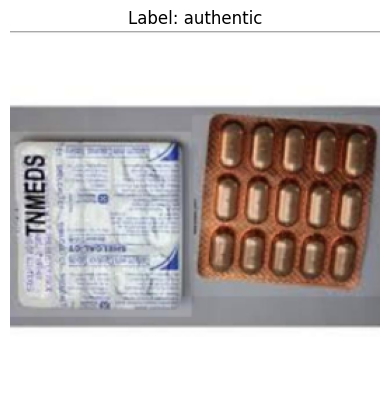

In [16]:
#visualize an image
image_num = 800 #@param {type:"raw"}
image, label = train_dataset[image_num]
image = image.permute(1, 2, 0).numpy()  # Convert to HWC numpy array

plt.imshow(image)
plt.title(f"Label: {'authentic' if label==0 else 'counterfeit'}")
plt.axis('off')
plt.show()

# Preproccessing

# Model Building

In [17]:
#set device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
        )


        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*33*33, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x
model = ConvNet().to(device)

In [19]:
#summarize model
summary(model, (3, 264, 264))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 264, 264]             448
       BatchNorm2d-2         [-1, 16, 264, 264]              32
              ReLU-3         [-1, 16, 264, 264]               0
         MaxPool2d-4         [-1, 16, 132, 132]               0
            Conv2d-5         [-1, 32, 132, 132]           4,640
       BatchNorm2d-6         [-1, 32, 132, 132]              64
              ReLU-7         [-1, 32, 132, 132]               0
         MaxPool2d-8           [-1, 32, 66, 66]               0
            Conv2d-9           [-1, 64, 66, 66]          18,496
      BatchNorm2d-10           [-1, 64, 66, 66]             128
             ReLU-11           [-1, 64, 66, 66]               0
        MaxPool2d-12           [-1, 64, 33, 33]               0
          Flatten-13                [-1, 69696]               0
           Linear-14                  [

# Model Training

In [20]:
#create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [21]:
# Create Loss function and optimizer
#make misclassificatino of counterfeits costlier
weights = torch.tensor([1.0, 3952/120], device = device)
criterion = nn.CrossEntropyLoss(weight = weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
batch = next(iter(train_dataloader))
print(type(batch))
print(len(batch))



<class 'list'>
2


In [23]:
#Create train loop
def train_loop(train_dataloader, model, loss_fn, optimizer, epochs):
  model = model.to(device)
  model.train()
  train_loss = []


  for epoch in range(epochs):


        running_loss = 0
        running_corrects = 0

        for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
            images = images.to(device)
            labels = labels.to(device)


            outputs = model(images)
            loss = loss_fn(outputs, labels)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            running_corrects += torch.sum(preds == labels).item()
            avg_loss = running_loss / len(train_dataloader.dataset)
            train_loss.append(avg_loss)

        print(f" Loss: {avg_loss}")

        epoch_train_loss = running_loss / len(train_dataloader.dataset)
        epoch_train_acc  = running_corrects / len(train_dataloader.dataset)
  return train_loss

In [24]:
# Train model
losses = train_loop(train_dataloader, model, criterion, optimizer, epochs=10)

Epoch 1/10 [Training]: 100%|██████████| 128/128 [00:35<00:00,  3.59it/s]


 Loss: 0.740547940394821


Epoch 2/10 [Training]: 100%|██████████| 128/128 [00:34<00:00,  3.69it/s]


 Loss: 0.07614795544755613


Epoch 3/10 [Training]: 100%|██████████| 128/128 [00:34<00:00,  3.73it/s]


 Loss: 0.05414590998585903


Epoch 4/10 [Training]: 100%|██████████| 128/128 [00:34<00:00,  3.68it/s]


 Loss: 0.0484659202752634


Epoch 5/10 [Training]: 100%|██████████| 128/128 [00:34<00:00,  3.73it/s]


 Loss: 0.034761382039894935


Epoch 6/10 [Training]: 100%|██████████| 128/128 [00:34<00:00,  3.75it/s]


 Loss: 0.0485998096397034


Epoch 7/10 [Training]: 100%|██████████| 128/128 [00:34<00:00,  3.74it/s]


 Loss: 0.03154585407100824


Epoch 8/10 [Training]: 100%|██████████| 128/128 [00:33<00:00,  3.83it/s]


 Loss: 0.03179248344635866


Epoch 9/10 [Training]: 100%|██████████| 128/128 [00:33<00:00,  3.77it/s]


 Loss: 0.035247106989968566


Epoch 10/10 [Training]: 100%|██████████| 128/128 [00:34<00:00,  3.73it/s]

 Loss: 0.027888348519021378


# Model Evaluation

In [25]:
def eval_loop(dataloader, model, loss_fn):
    model.eval()
    running_correct = 0
    running_total = 0


    with torch.no_grad():
      for image, label in tqdm(test_dataloader, desc="Testing Model"):
        image, label = image.to(device), label.to(device)
        id = model(image)

        running_correct += (id.argmax(1) == label).type(torch.float).sum().item()
        running_total += len(label)
    accuracy = running_correct / running_total
    print(f"Accuracy: {accuracy}")
    return accuracy



In [26]:
eval_loop(test_dataloader, model, criterion)

Testing Model: 100%|██████████| 3/3 [00:00<00:00,  6.47it/s]

Accuracy: 0.9846153846153847


0.9846153846153847

In [27]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_auc_score, roc_curve
)

In [28]:
#Create confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print(cm)





[[110   0]
 [  7   5]]


#Model Testing

In [31]:
def test_loop(train_dataloader, model, loss_fn, device, class_names = None):
  model.eval()
  all_preds = []
  all_labels = []
  all_probs = []
  running_loss = 0.0

  with torch.no_grad():
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # prediction probabilities
            preds = torch.argmax(outputs, dim=1)

            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * images.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

  test_loss = running_loss / len(train_dataloader.dataset)
  test_acc = np.mean(np.array(all_preds) == np.array(all_labels))

  print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}\n")

  # Classification Report
  print("Classification Report:")
  print(classification_report(all_labels, all_preds, target_names=class_names))

  # Confusion Matrix
  cm = confusion_matrix(all_labels, all_preds)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(cmap=plt.cm.Blues, values_format='d')
  plt.title("Confusion Matrix")
  plt.show()

  # ROC-AUC
  if len(set(all_labels)) == 2:
      auc = roc_auc_score(all_labels, np.array(all_probs)[:,1])
      fpr, tpr, _ = roc_curve(all_labels, np.array(all_probs)[:,1])
      print(f"ROC-AUC: {auc:.4f}")

      plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
      plt.plot([0,1], [0,1], linestyle="--")
      plt.xlabel("False Positive Rate")
      plt.ylabel("True Positive Rate")
      plt.title("ROC Curve")
      plt.legend()
      plt.show()

  return test_loss, test_acc, cm

Test Loss: 0.0221 | Test Accuracy: 0.9912

Classification Report:
              precision    recall  f1-score   support

   authentic       0.99      1.00      1.00      3952
 counterfeit       0.97      0.72      0.83       120

    accuracy                           0.99      4072
   macro avg       0.98      0.86      0.91      4072
weighted avg       0.99      0.99      0.99      4072



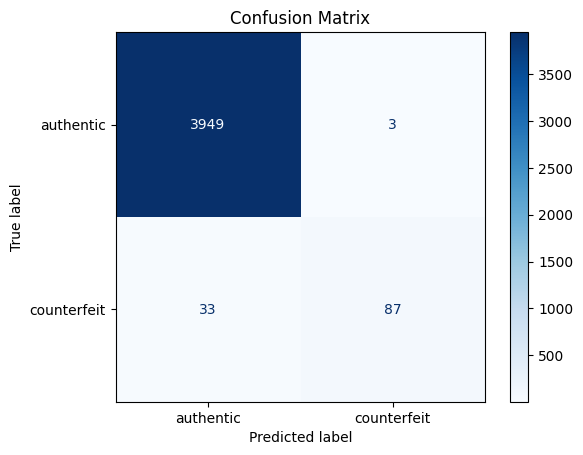

ROC-AUC: 0.9981


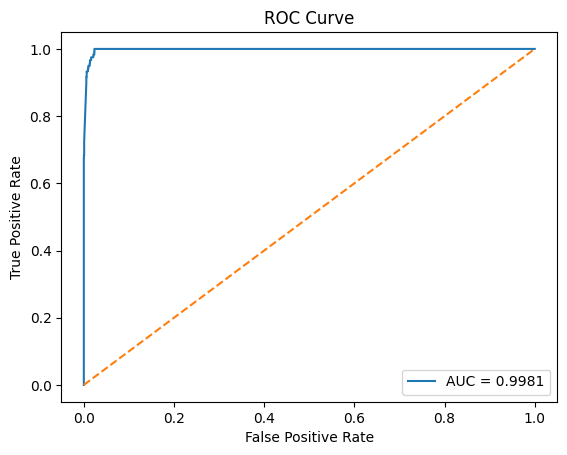

In [32]:
test_loss, test_acc, cm = test_loop(train_dataloader, model, criterion, device, class_names=['authentic','counterfeit'])


# Final Implementation

In [ ]:
#Final implementation
idx_to_class = {0: "Counterfeit", 1: "Authentic"}

def visualize_prediction(model, dataset, device="cuda", index=None):
    model.eval()

    if index is None:
        index = torch.randint(0, len(dataset), (1,)).item()

    image, label = dataset[index]

    # Prepare image for model
    input_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        _, pred = torch.max(outputs, 1)
        pred_class = idx_to_class[pred.item()]
        true_class = idx_to_class[label]

    # Show image
    plt.imshow(image.permute(1, 2, 0))  # Convert from CxHxW to HxWxC
    plt.axis("off")
    plt.title(f"Predicted: {pred_class} | True: {true_class}")
    plt.show()


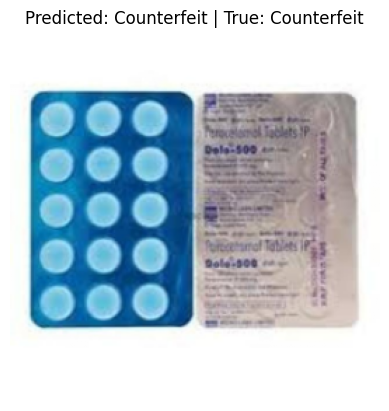

In [ ]:
visualize_prediction(model, test_dataset)
